# Artificial Intelligence
## Image Generator

OpenAI Dall-E (and others) are text-to-image models developed by OpenAI using deep learning methodologies to generate digital images from natural language descriptions, called "prompts".

Reference:

+ https://gemini.google.com/app
+ https://openai.com/index/dall-e-2/
+ https://cloud.google.com/vertex-ai/generative-ai/docs/image/img-gen-prompt-guide
+ https://tech.co/news/use-google-bard-ai-image-generator

In [1]:
PROJECT_NAME="ai-training-2024-08-09-bucket"

## Environment Check

In [2]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import sys
import subprocess
import importlib.util

RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    print("You are running this notebook in Google Colab.")
else:
    print("You are running this notebook with Jupyter iPython runtime.")

You are running this notebook with Jupyter iPython runtime.


## Libraries

In [3]:
############################################
# INCLUDES
############################################
#libraries specific to this example
## Imports
#import tensorflow as tf
#from tensorflow import keras

from IPython import display

#a set of libraries that perhaps should always be in Python source
import os
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import textwrap
import random
import glob
import os
import PIL
import time
import subprocess

#images
import imageio
import matplotlib as matplt
import matplotlib.pyplot as plt

#data science
import numpy as np

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

warnings.filterwarnings('ignore')               # don't print out warnings

## Variables

In [4]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "MLGENIMG"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS
############################################
BUFFER_SIZE = 60000
BATCH_SIZE = 256
TEXT_WIDTH=77
############################################
# APPLICATION VARIABLES
############################################
start = "\033[1m"
end = "\033[0;0m"

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


## Function

In [5]:
## Outputs library version history of effort.
#
#  @returns (None)                  - None
def lib_diagnostics() -> None:

    import pkg_resources
    
    package_name_length=40
    package_version_length=20

    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             print(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")
   
    try:
        print(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        print(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        print(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        print(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        print(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        print(f"{'     count':<40}#: {torch.cuda.device_count()}")
        print(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass


    try:
      print(f"{'OpenAI Azure Version':<40}#: {str(the_openai_version):<20}")
    except Exception as e:
      pass
    return

## Function Call

In [6]:
lib_diagnostics()
wrapper = textwrap.TextWrapper(width=TEXT_WIDTH)

nltk                                    #: 3.8.1               
numpy                                   #: 1.24.4              
pandas                                  #: 2.2.2               


## Input Sources



## Large Language Model (LLM) ~ Gemini Visual Model (Google)

In [7]:
#Download Google Vextex/AI Libraries
subprocess.run(["pip", "install" , "--upgrade", "google-cloud-aiplatform", "--quiet"])


libraries=["google-generativeai", "google-cloud-secret-manager"]

for library in libraries:  
    spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"])
    else:
      print("Library " + library + " already installed.")

from google.cloud import aiplatform
import vertexai.preview
from google.cloud import secretmanager

Installing library google-generativeai
Installing library google-cloud-secret-manager


In [8]:
#show your library versions
try:
  print("GCP AI Platform version#:{:>12}".format(aiplatform.__version__))
except Exception as e:
  pass

try:
  print("GCP Vertex version     #:{:>12}".format(vertexai.__version__))
except Exception as e:
  pass

try:
  print("Secret Manager version #:{:>12}".format(secretmanager.__version__))
except Exception as e:
  pass

GCP AI Platform version#:      1.62.0
GCP Vertex version     #:      1.62.0
Secret Manager version #:      2.20.2


In [9]:
#authenticate so you can use the model
#follow the instructions shown in the executed block below.
#Note that to the right of the "Do you want to continue?" will be a text box you provide "Y" input into.
#Follow the URL, copy the code and paste it next to "browser:" on the subsequent line's text box.
if RunningInCOLAB:
  !gcloud auth application-default login

In [9]:
# Setup the required connection for using the model
# Get api key from secret manager
client          = secretmanager.SecretManagerServiceClient()
secret_name     = "usfs-gcp-rand-test-genai-api-key"
secret_version  = "latest"
project_id      = "usfs-tf-admin"
resource_name   = f"projects/{project_id}/secrets/{secret_name}/versions/{secret_version}"
#print(resource_name)

# Get secret
response=client.access_secret_version(request={"name":resource_name})
payload = response.payload.data.decode("UTF-8")
GOOGLE_API_KEY = payload

In [10]:
safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
]

In [12]:
import google.generativeai as genai
from vertexai.preview.vision_models import ImageGenerationModel

# Create the model
# See https://ai.google.dev/api/python/google/generativeai/GenerativeModel

# Create the model
# See https://ai.google.dev/api/python/google/generativeai/GenerativeModel
generation_config = {
  "temperature": 0.9,
  "top_p": 1,
  "top_k": 0,
  "max_output_tokens": 2048,
  "response_mime_type": "text/plain",
}

model_definition="imagegeneration@006"

model = ImageGenerationModel.from_pretrained(model_definition)

## Create Your Picture Prompt

In [13]:
#options for creating an image
style=["normal", "abstract", "surrealism", "cubism", "impressionism", "3d", "expressionist painting", "manga", "pop art", "pencil sketch", "watercolor"]
detail=["normal", "realistic", "ultrarealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "intricate", "highly detailed"]
position=["normal", "on the wall", "in the background", "in the foreground", "in the middle", "in the left", "in the right"]
mood=["normal", "stunning", "elegant", "radiant", "delicate", "cute", "striking" "glamorous"]
lights=["normal", "warm lighting", "natural lighting", "cold lighting", "dark aesthetic", "red tones", "blue tones"]
viewpoint=["portrait", "landscape", "close-up", "headshot", "mid-range", "3/4 shot", "full body shot", "wide shot", "low angle shot", "high angle shot"]
subject=["penguin", "bear", "tree", "dog", "cat"]
verb=["running", "surfing", "on the computer", "sleeping", "eating", "playing", "dancing", "sitting", "standing", "walking"]



#generate a picture from random choices above
picture_prompt=f"{style[random.randint(0, len(style)-1)]} \
 {detail[random.randint(0, len(detail)-1)]} \
 {position[random.randint(0, len(position)-1)]} \
 {mood[random.randint(0, len(mood)-1)]} \
 {lights[random.randint(0, len(lights)-1)]} \
 {viewpoint[random.randint(0, len(viewpoint)-1)]}\
 {subject[random.randint(0, len(subject)-1)]} \
 {verb[random.randint(0, len(verb)-1)]}"

#examples
#picture_prompt="magazine style, 4k, photorealistic, modern red armchair, natural"
#picture_prompt="oil painting, 4k, happy bear surfing"


#format the output to make it legible
string = wrapper.fill(text=picture_prompt)
print(string)


3d  photorealistic  in the right  strikingglamorous  natural lighting  full
body shot bear  dancing


## Execute the Image Generation

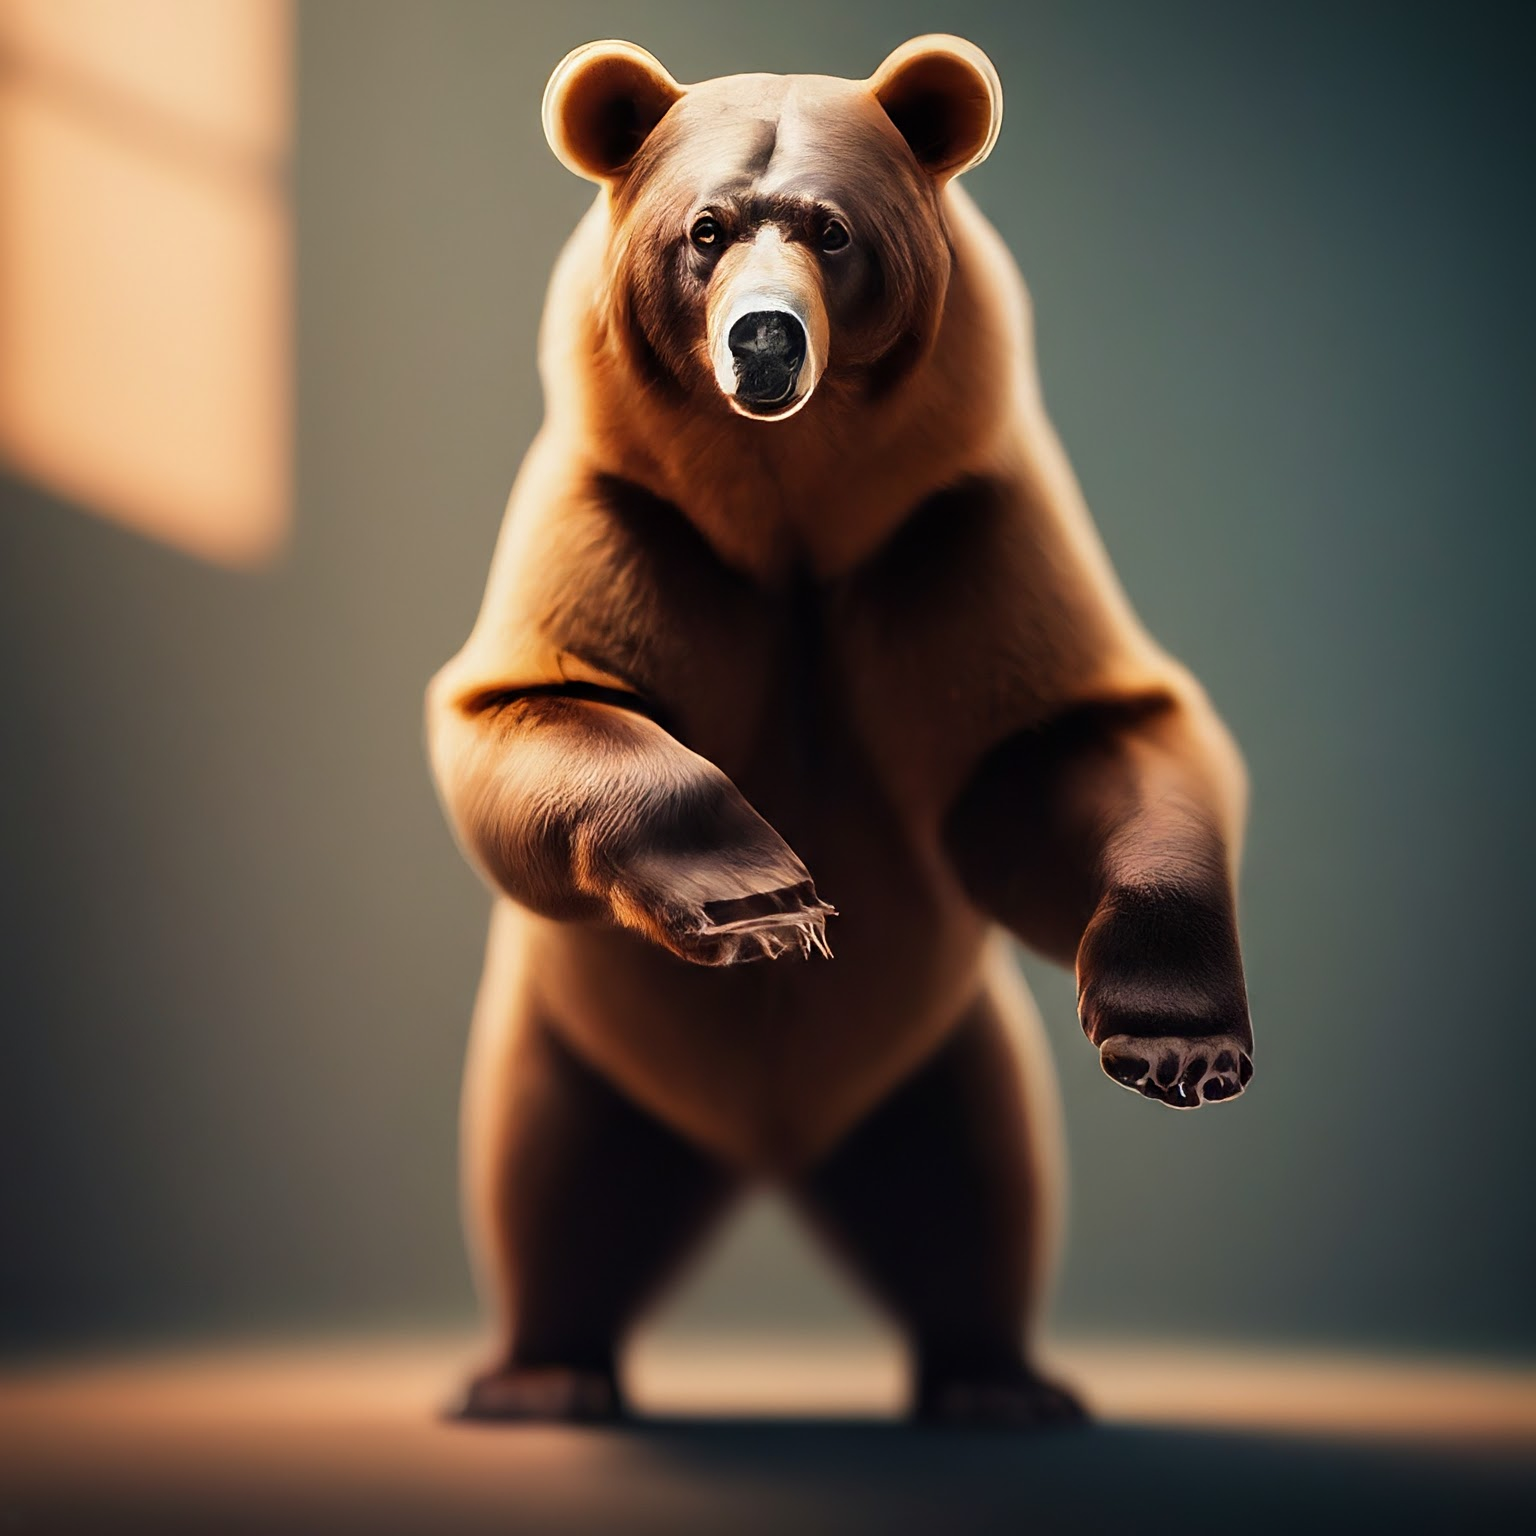

Created output image using 1485347 bytes


In [14]:


try:
  images = model.generate_images(
      prompt=picture_prompt,

      # Optional parameters
      number_of_images=1,
      language="en",

      # You can't use a seed value and watermark at the same time.
      # add_watermark=False,
      # seed=100,
      aspect_ratio="1:1",
      safety_filter_level="block_some",
      person_generation="allow_adult",
  )

  try:
    output_file="./folderOnColab/output.png"
    images[0].save(location=output_file, include_generation_parameters=False)
  except Exception as e:
    print("There was a problem saving your image.")
    print(f"{start}See exception:{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
    print(f"Your save location was {output_file}.")

  # Optional. View the generated image in a notebook.
  try:
    images[0].show()
    print(f"Created output image using {len(images[0]._image_bytes)} bytes")
  except Exception as e:
    print("There was a problem displaying your image.")
    print(f"{start}See exception:{end} ")
    string = wrapper.fill(text=str(e))
    print(string)

except Exception as e:
  print("There was a problem creating your image.")
  print("\n")
  print(f"{start}See exception:{end} ")
  string = wrapper.fill(text=str(e))
  print(string)
  print("\n")
  print(f"{start}Your prompt was:{end} ")
  string = wrapper.fill(text=picture_prompt)
  print(string)


